### Создание и обучение модели Unet

In [157]:
#!g1.1
import numpy as np 
import time
import random
import os

import tensorflow as tf
from tensorflow.keras.models import Model       
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import Reshape, GlobalAveragePooling2D, UpSampling2D, AveragePooling2D
from tensorflow.keras import backend as K        
from tensorflow.keras.optimizers import Adam, SGD     
from tensorflow.keras import utils               
from tensorflow.keras.preprocessing import image 
from sklearn.model_selection import train_test_split
from keras.models import load_model
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt  
# from PIL import Image 

In [158]:
#!g1.1
SEED = 1111
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [159]:
#!g1.1
# Путь к сохраненным выборкам
data_path = "/home/jupyter/work/resources/NIIAS-RZD/data_np"
# Путь для сохранения моделей
model_path = "/home/jupyter/work/resources/NIIAS-RZD/models"

In [160]:
#!g1.1
# Список выборок
np_files  = []
for file_name in sorted(os.listdir(data_path)):
    if 'data' in file_name:
        np_files.append(file_name)
print("Имеем {} сохраненных выборок".format(len(np_files)))

Имеем 40 сохраненных выборок


In [161]:
#!g1.1
# Загрузим пример сохраненной выборки
np_file = random.choice(np_files)
print(np_file)
data = np.load(os.path.join(data_path, np_file))
images_np = data['a']
anns_np = data['b']
print(images_np.shape, anns_np.shape)

data14.npz
(800, 432, 768, 3) (800, 432, 768, 4)


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:873: UserWarning: The following variables cannot be serialized: data
  warnings.warn(message)


In [162]:
#!g1.1
# Размеры, изображения
img_height = images_np.shape[1]      # 432
img_width = images_np.shape[2]       # 768
print(img_height, img_width)

432 768


In [163]:
#!g1.1
# Классов сегментации
classes = [0, 6, 7, 10]
num_classes = len(classes)
print(num_classes)

4


### Создание Unet

In [164]:
#!g1.1
# Функция метрики, обрабатывающая пересечение двух областей
def dice_coef(y_true, y_pred):
  # Возвращаем площадь пересечения деленную на площадь объединения двух областей
  return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) 

In [165]:
#!g1.1
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unet(num_classes = 4, input_shape= (432, 768, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                        # Добавляем слой MaxPooling2D

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_1_out])                                      # Объединем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model 

**Новую модель создавать только один (первый) раз.**

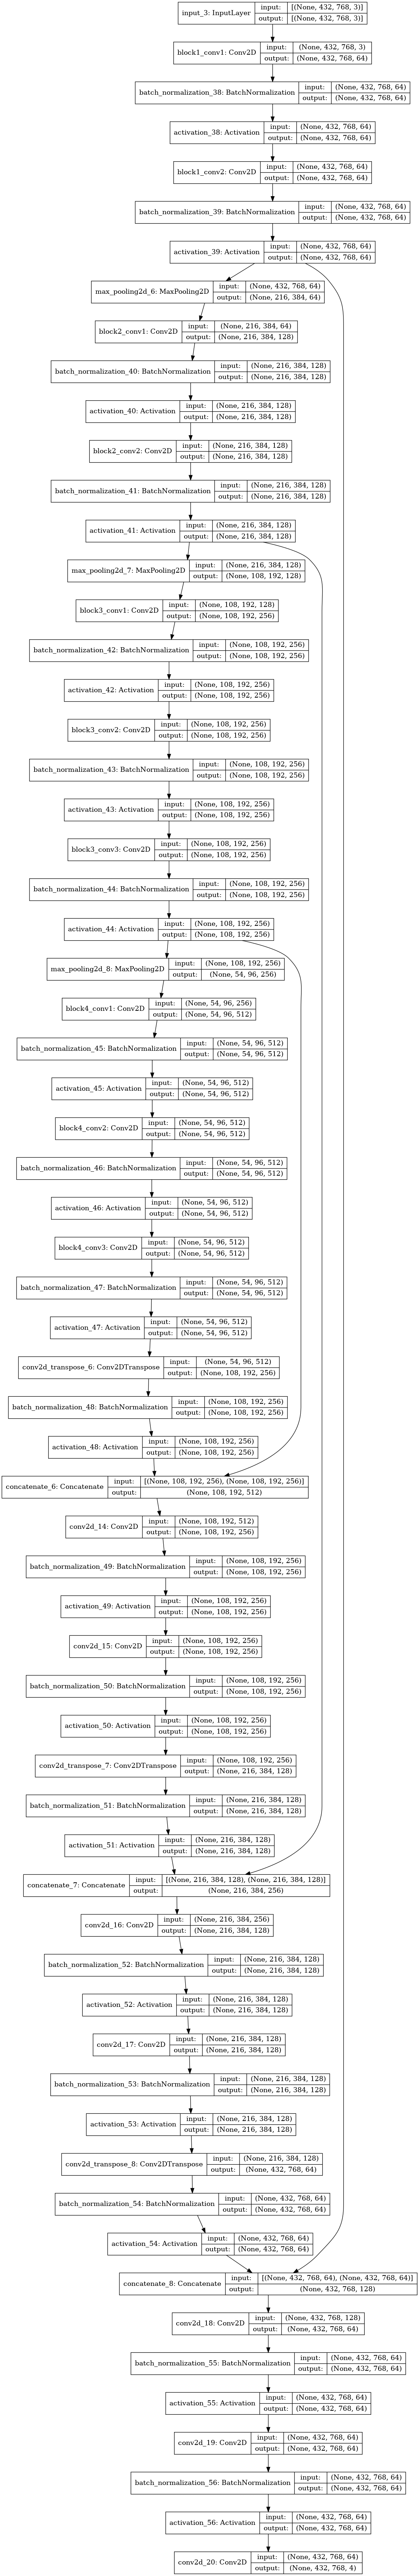

In [171]:
#!g1.1
# Создаем модель и сохраняем ее 
modelUnet = unet(num_classes, (img_height, img_width, 3))
# modelUnet.summary()
# plot_model(modelUnet, to_file="modelUnet.png", show_shapes=True)

model_file = os.path.join(model_path, '00-Unet')
modelUnet.save(model_file, save_format='tf')

**Поправить имя сохраненной модели, с которой продолжаем обучение**

In [ ]:
#!g1.1
# Обучаем на нескольких выборках
N_np = 1
start_from = 30 # нумерации файлов 

history_list = []

# Загружаем модель (поправить вручную)
model_file = os.path.join(model_path, '27-Unet') # ИМЯ МОДЕЛИ
modelUnet = load_model(model_file, custom_objects={'dice_coef':dice_coef})


# Перекомпилируем 
lr = 0.0001 
modelUnet.compile(optimizer=Adam(lr=lr),
              loss='categorical_crossentropy',
              metrics=[dice_coef])
# modelUnet.compile(loss='categorical_crossentropy', 
#                   optimizer=SGD(learning_rate=lr, momentum=0.9), 
#                   metrics=[dice_coef])

cur_time = time.time()
for n in range(N_np):
    np_file = np_files[start_from + n -1]
    data = np.load(os.path.join(data_path, np_file))
    images_np = data['a']
    anns_np = data['b']
    print("\nОбучение на выборке {}".format(np_file))
    
    x_train, x_val, y_train, y_val = train_test_split(images_np, anns_np, test_size=0.15, shuffle=True)   
    
    history = modelUnet.fit(x_train, y_train, epochs=10, batch_size=2, validation_data = (x_val, y_val)) 
    history_list.append(history)
    
    file_number = "%02d" % (start_from + n)
    model_file = os.path.join(model_path, file_number + '-Unet')
    modelUnet.save(model_file, save_format='tf')
    
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')

In [ ]:
#!g1.1
#Отображаем график точности в процессе обучения
history_acc = []
history_val = []
for N in range(len(history_list)):
    history_acc = history_acc + history_list[N].history['dice_coef']
    history_val = history_val + history_list[N].history['val_dice_coef']

plt.figure(figsize=(16,5))
plt.plot(history_acc, 
         label='dice_coef')
plt.plot(history_val, 
         label='val_dice_coef')
plt.xlabel('Эпоха обучения')
plt.ylabel('Метрики')
plt.legend()
plt.show()

# Максимальная точность
val_acc = np.array(history_val)
print('Максимальная точность val_dice_coef = {} на эпохе {}.'.format(round(val_acc.max(),4), val_acc.argmax()))